##Importing libraries

In [82]:
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error


##Loading the dataset

In [83]:
weather_data = pd.read_csv('/content/local_weather.csv',index_col='DATE')

In [ ]:
weather_data.head()

In [ ]:
weather_data.loc['1960-01-01']

##Data Cleaning ... 
###Only take columns which give us precipitation and the min and the max temps

In [ ]:
weather_data.apply(pd.isnull).sum()/weather_data.shape[0]

In [87]:
weather_data_imp = weather_data[['PRCP','SNOW','SNWD','TMAX','TMIN']].copy()

In [88]:
weather_data_imp.columns = ['precip','snow','snow_depth','temp_max','temp_min']

In [89]:
weather_data_imp.apply(pd.isnull).sum()/weather_data_imp.shape[0]

precip        0.016668
snow          0.324990
snow_depth    0.317634
temp_max      0.000534
temp_min      0.000593
dtype: float64

In [90]:
weather_data_imp['snow'].value_counts()

0.0    11379
1.0        1
Name: snow, dtype: int64

In [91]:
del weather_data_imp['snow']

In [92]:
del weather_data_imp['snow_depth']

In [ ]:
weather_data_imp

In [ ]:
weather_data_imp[pd.isnull(weather_data_imp['precip'])]

In [ ]:
weather_data_imp['precip'].value_counts()

In [96]:
weather_data_imp['precip'] = weather_data_imp['precip'].fillna(0)

In [ ]:
weather_data_imp[pd.isnull(weather_data_imp['temp_max'])]
#Use forward fill which is to impute the previous value to the null value

In [98]:
weather_data_imp = weather_data_imp.fillna(method = 'ffill')

In [99]:
weather_data_imp.dtypes

precip      float64
temp_max    float64
temp_min    float64
dtype: object

In [100]:
weather_data_imp.index = pd.to_datetime(weather_data_imp.index)

In [ ]:
weather_data_imp.index

In [102]:
#Checking whether data set is missing values indicated in the dataset by the value 9999
weather_data_imp.apply(lambda x: (x==9999).sum())

precip      0
temp_max    0
temp_min    0
dtype: int64

##EDA

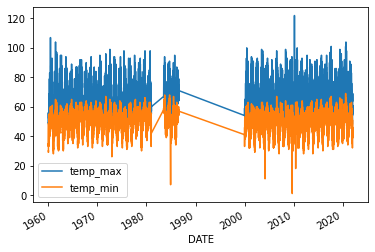

In [103]:
weather_data_imp[['temp_max','temp_min']].plot()

In [ ]:
#Find the gaps
weather_data_imp.index.year.value_counts()

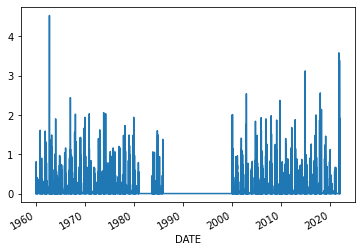

In [105]:
weather_data_imp['precip'].plot()

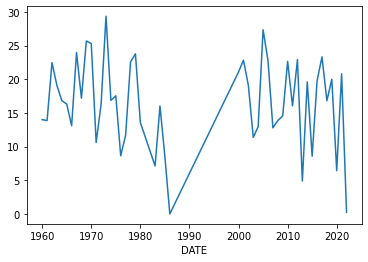

In [106]:
weather_data_imp.groupby(weather_data_imp.index.year).sum()['precip'].plot()

##Model selection and training

In [107]:
#Creating a target variable which is shifted by -1 to create tomorrow's temp
weather_data_imp['target'] = weather_data_imp.shift(-1)['temp_max']

In [108]:
weather_data_imp.tail()

,precip,temp_max,temp_min,target
DATE,,,,
2022-01-24,0.0,60.0,39.0,57.0
2022-01-25,0.0,57.0,43.0,57.0
2022-01-26,0.0,57.0,41.0,67.0
2022-01-27,0.0,67.0,39.0,64.0
2022-01-28,0.0,64.0,39.0,NaN


In [109]:
weather_data_imp = weather_data_imp.iloc[:-1,:].copy()

###Using Ridge regression 
#### This is done in order to reduce overfitting

In [110]:
reg = Ridge(alpha=.1)


In [131]:
#Uncomment for rolling avgs
predictors = ['precip','temp_max','temp_min','month_max','month_day_max','max_min','monthly_avg','day_of_year_avg']

###Train Test data split

In [112]:
#Cannot be shuffled as it is a time series dataset
train = weather_data_imp.loc[:'2020-12-31']
test = weather_data_imp.loc['2021-01-01':]

In [113]:
reg.fit(train[predictors],train['target'])

Ridge(alpha=0.1)

###Checking model performance

In [114]:
predictions = reg.predict(test[predictors])

In [115]:
mean_absolute_error(test['target'],predictions)

3.4111699434528306

In [116]:
combined = pd.concat([test['target'],pd.Series(predictions,index = test.index)],axis = 1)
combined.columns = ['actual','predicted']

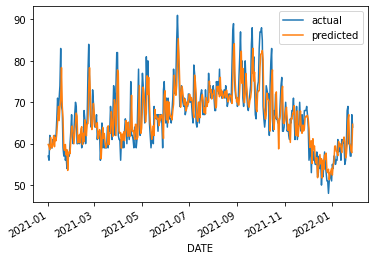

In [117]:
combined.plot()

In [118]:
reg.coef_

array([-2.20730384,  0.72113834,  0.17969047])

###Summarising previous steps as a function 

In [124]:
def create_predictions(predictors,weather_data_imp,reg):
  train = weather_data_imp.loc[:'2020-12-31']
  test = weather_data_imp.loc['2021-01-01':]
  reg.fit(train[predictors],train['target'])
  predictions = reg.predict(test[predictors])
  error = mean_absolute_error(test['target'],predictions)
  combined = pd.concat([test['target'],pd.Series(predictions,index = test.index)],axis = 1)
  combined.columns = ['actual','predicted']
  return error,combined

##Creating rolling variables for better predictions

In [119]:
weather_data_imp['month_max'] = weather_data_imp['temp_max'].rolling(30).mean()
#First 30 days will be null

In [ ]:
weather_data_imp

In [120]:
#How much is the daily max temp off from the monthly max average temp
weather_data_imp['month_day_max'] = weather_data_imp['month_max']/weather_data_imp['temp_max']
#Ratio between the maximum and the minimum temperature
weather_data_imp['max_min'] = weather_data_imp['temp_max']/weather_data_imp['temp_min']

In [70]:
new_vars = 'month_max','month_day_max','max_min'
predictors.append(new_vars)

In [122]:
weather_data_imp = weather_data_imp.iloc[30:,:].copy()

In [125]:
error,combined = create_predictions(predictors,weather_data_imp,reg)

In [126]:
error

3.3601297462076047

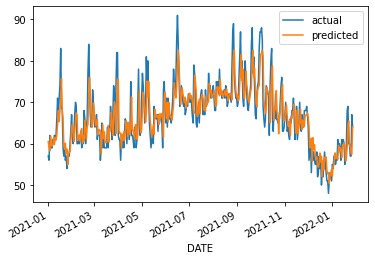

In [127]:
combined.plot()

##Adding a monthly average temp variable

In [130]:
#Monthly avg should be calculated for only the preceeding observations as it is time series data. Avoid future knowledge bias
#Monthly average for historic data
weather_data_imp['monthly_avg'] = weather_data_imp['temp_max'].groupby(weather_data_imp.index.month).apply(lambda x: x.expanding(1).mean())
#Daily average for historic data
weather_data_imp['day_of_year_avg'] = weather_data_imp['temp_max'].groupby(weather_data_imp.index.day_of_year).apply(lambda x: x.expanding(1).mean())

In [132]:
weather_data_imp.head()

,precip,temp_max,temp_min,target,month_max,month_day_max,max_min,monthly_avg,day_of_year_avg
DATE,,,,,,,,,
1960-01-31,0.00,59.0,46.0,62.0,55.566667,0.941808,1.282609,59.0,59.0
1960-02-01,0.81,62.0,51.0,59.0,56.000000,0.903226,1.215686,62.0,62.0
1960-02-02,0.00,59.0,43.0,59.0,56.166667,0.951977,1.372093,60.5,59.0
1960-02-03,0.20,59.0,47.0,60.0,56.333333,0.954802,1.255319,60.0,59.0
1960-02-04,0.16,60.0,42.0,60.0,56.500000,0.941667,1.428571,60.0,60.0


##Assessing model performance after adding the monthly and daily average metrics to the dataset

In [133]:
error,combined = create_predictions(predictors,weather_data_imp,reg)

In [134]:
error

3.317692658765995

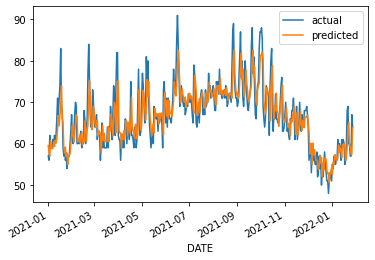

In [135]:
combined.plot()

In [136]:
reg.coef_

array([ -0.90804013,   0.40146278,   0.03114081,   0.33672074,
       -15.97061869,   0.0493612 ,   0.14343362,   0.08006707])

In [138]:
weather_data_imp.corr()['target']

precip            -0.205413
temp_max           0.821650
temp_min           0.596016
target             1.000000
month_max          0.686842
month_day_max     -0.421537
max_min            0.045228
monthly_avg        0.689805
day_of_year_avg    0.712334
Name: target, dtype: float64

In [140]:
combined['diff'] = combined['actual'] - combined['predicted'].abs()

In [141]:
combined.sort_values('diff',ascending=False).head()

,actual,predicted,diff
DATE,,,
2021-01-17,83.0,68.585837,14.414163
2021-05-07,81.0,67.774432,13.225568
2021-02-22,84.0,71.168844,12.831156
2021-02-21,77.0,64.415171,12.584829
2021-03-30,82.0,70.104917,11.895083


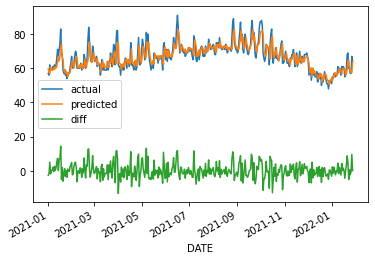

In [142]:
combined.sort_values('diff',ascending=False).plot()